In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import cv2
import glob as gb
import pandas as pd
import seaborn as sns
import matplotlib.image as mpimg
import imagehash
from PIL import Image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

#from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from keras.applications import DenseNet121

2024-01-20 16:46:25.617254: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-20 16:46:25.617513: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-20 16:46:25.902557: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-20 16:46:26.637726: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-20 16:46:30.767077: W tensorflow/compiler/tf2

In [2]:
train_path = '/home/bubbles/Quantbit Internship/Quality Check/Tomato Freshness Dataset/train'
test_path = '/home/bubbles/Quantbit Internship/Quality Check/Tomato Freshness Dataset/test'

In [3]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255,                # Rescale pixel values to [0, 1]
    rotation_range=20,              # Random rotation within 20 degrees
    width_shift_range=0.2,          # Random horizontal shift by 20% of image width
    height_shift_range=0.2,         # Random vertical shift by 20% of image height
    horizontal_flip=True,           # Random horizontal flipping
    fill_mode='nearest'             # Fill mode for new pixels after shifts/rotations
)

In [4]:
size_images = 200
batch_size = 64
train_generator = train_datagen.flow_from_directory(
    train_path,                     # Path to the training data
    target_size=(size_images, size_images),  # Resize images to this size
    batch_size=batch_size,           # Number of images in each batch
    seed=32,                         # Optional: Set a random seed for shuffling
    shuffle=True,                    # Shuffle the data during training
    class_mode='categorical'        # Mode for class labels (categorical for one-hot encoding)
)

Found 1895 images belonging to 2 classes.


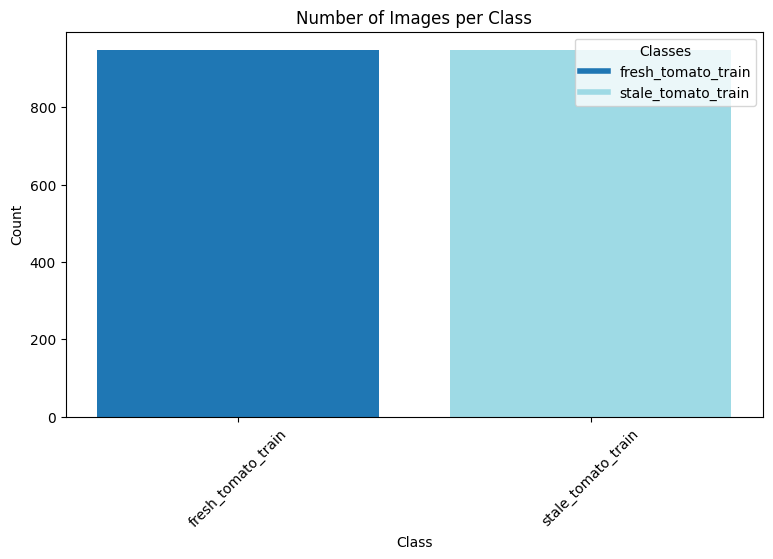

In [5]:
class_labels = list(train_generator.class_indices.keys())

# Calculate the count of images per class
class_counts = {label: 0 for label in class_labels}

for i in range(len(train_generator)):
    batch_data, batch_labels = train_generator[i]
    for j in range(len(batch_data)):
        class_idx = int(batch_labels[j].argmax())
        class_label = class_labels[class_idx]
        class_counts[class_label] += 1

# Define unique colors for each class
class_colors = plt.cm.tab20(np.linspace(0, 1, len(class_labels)))

# Create a bar chart with different colors for each class
plt.figure(figsize=(9, 5))
bars = plt.bar(class_counts.keys(), class_counts.values(), color=class_colors)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Number of Images per Class')
plt.xticks(rotation=45)

# Add a legend for class colors
legend_labels = [plt.Line2D([0], [0], color=class_colors[i], lw=4, label=class_labels[i]) for i in range(len(class_labels))]
plt.legend(handles=legend_labels, title="Classes")

plt.show()

Found 68 images belonging to 2 classes.


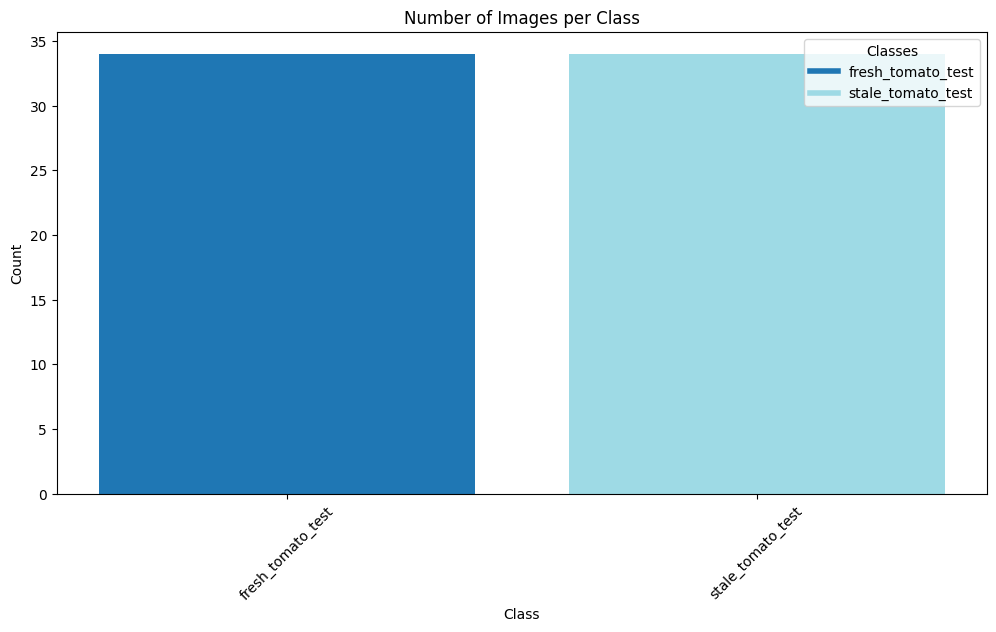

In [6]:
test_datagen = ImageDataGenerator(rescale=1.0/255)
test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(size_images, size_images),
    batch_size = batch_size,
    class_mode='categorical')
class_labels = list(test_generator.class_indices.keys())

# Calculate the count of images per class
class_counts = {label: 0 for label in class_labels}

for i in range(len(test_generator)):
    batch_data, batch_labels = test_generator[i]
    for j in range(len(batch_data)):
        class_idx = int(batch_labels[j].argmax())
        class_label = class_labels[class_idx]
        class_counts[class_label] += 1

# Define unique colors for each class
class_colors = plt.cm.tab20(np.linspace(0, 1, len(class_labels)))

# Create a bar chart with different colors for each class
plt.figure(figsize=(12, 6))
bars = plt.bar(class_counts.keys(), class_counts.values(), color=class_colors)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Number of Images per Class')
plt.xticks(rotation=45)

# Add a legend for class colors
legend_labels = [plt.Line2D([0], [0], color=class_colors[i], lw=4, label=class_labels[i]) for i in range(len(class_labels))]
plt.legend(handles=legend_labels, title="Classes")

plt.show()

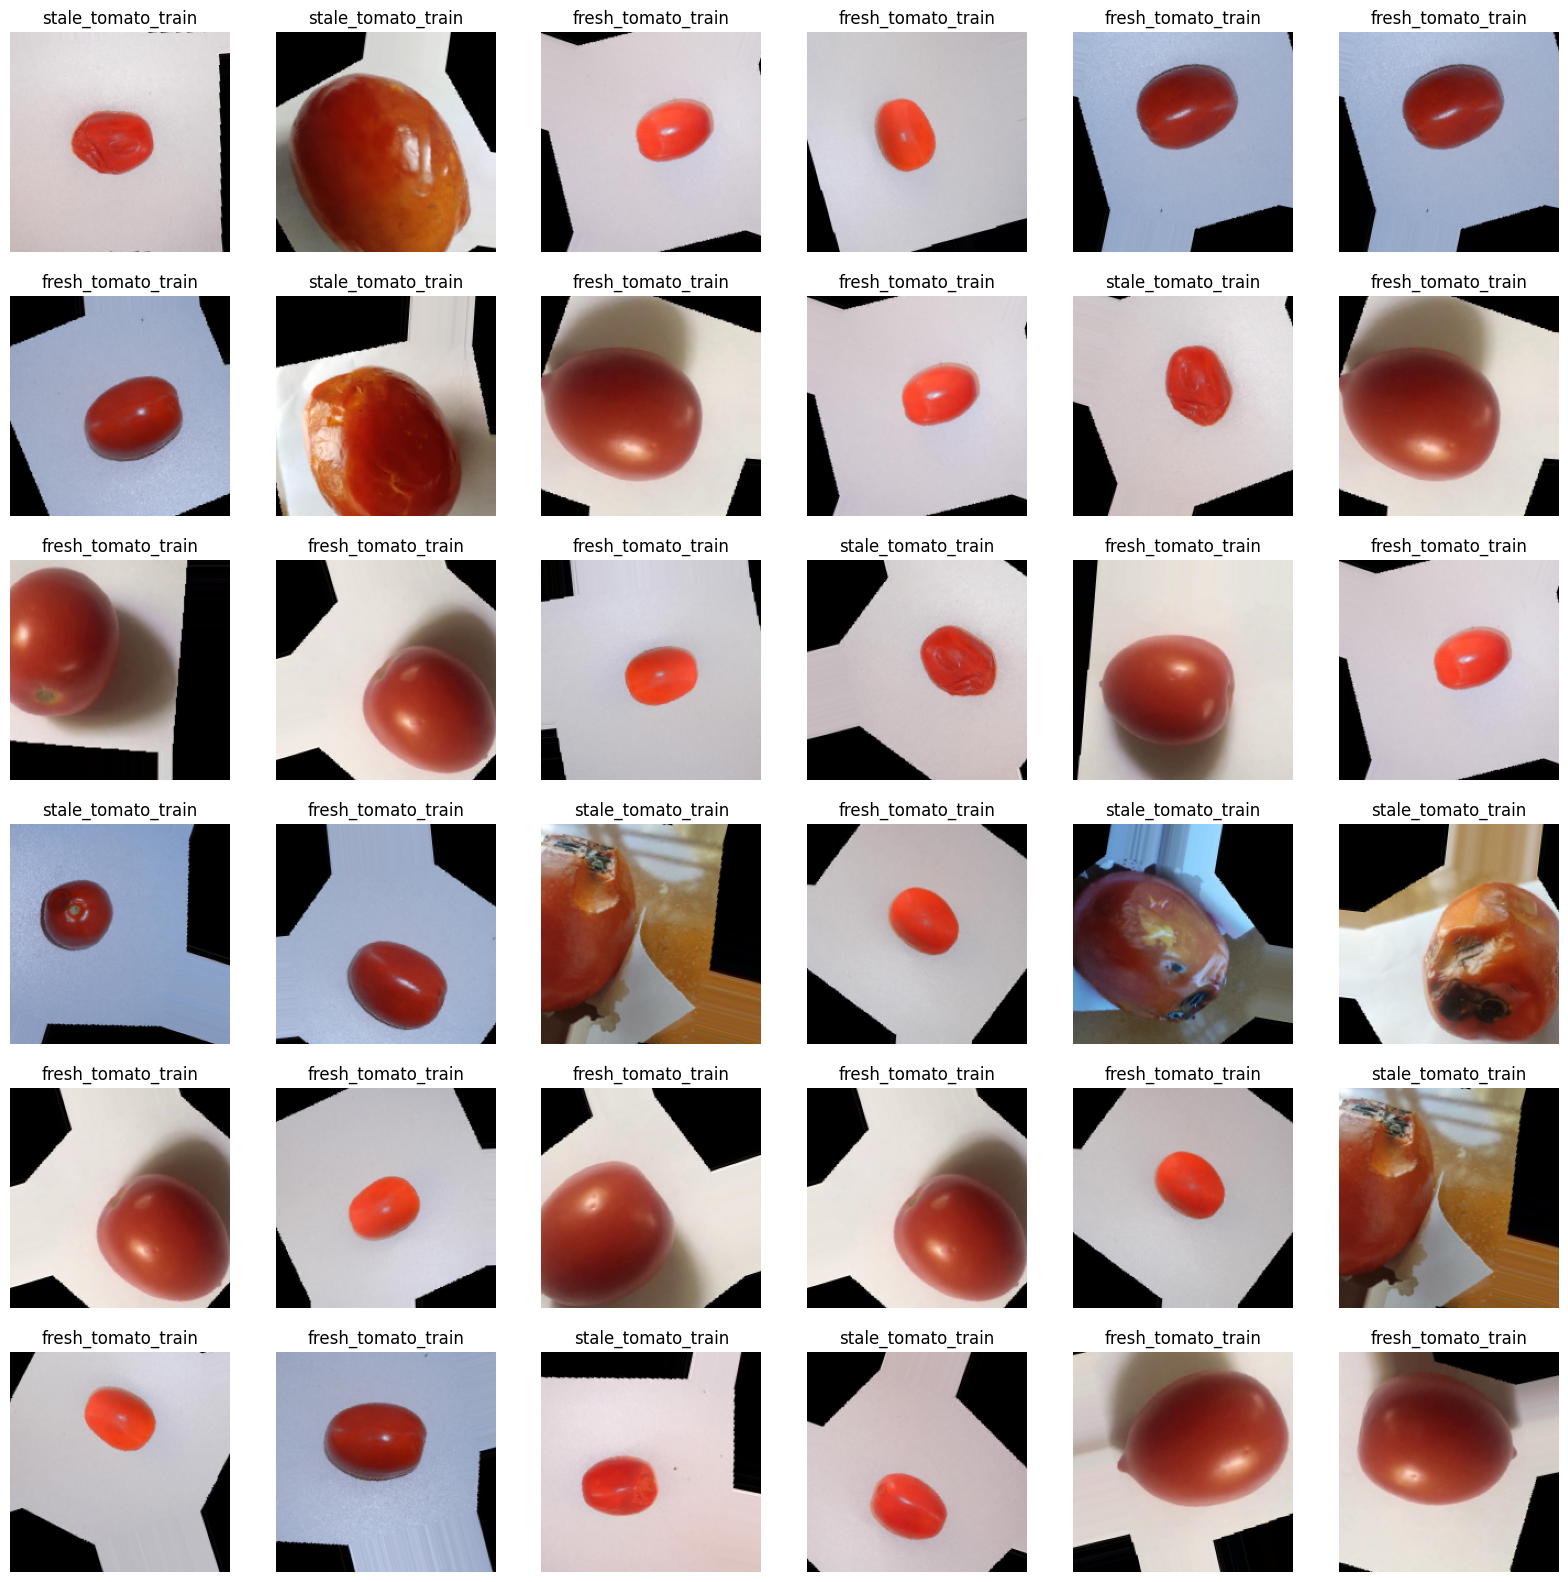

In [7]:
def Show_Images(target_gen):
    # Get a batch of images and labels
    batch_images, batch_labels = next(target_gen)

    # Get class labels
    class_labels = list(target_gen.class_indices.keys())

    # Display images with labels
    plt.figure(figsize=(20, 20))
    for n , i in enumerate(list(np.random.randint(0,len(batch_images),36))):
        plt.subplot(6, 6, n + 1)
        plt.imshow(batch_images[i])
        plt.title(class_labels[np.argmax(batch_labels[i])])  # Display the class label
        plt.axis('off')
    plt.show()


Show_Images(train_generator)

    

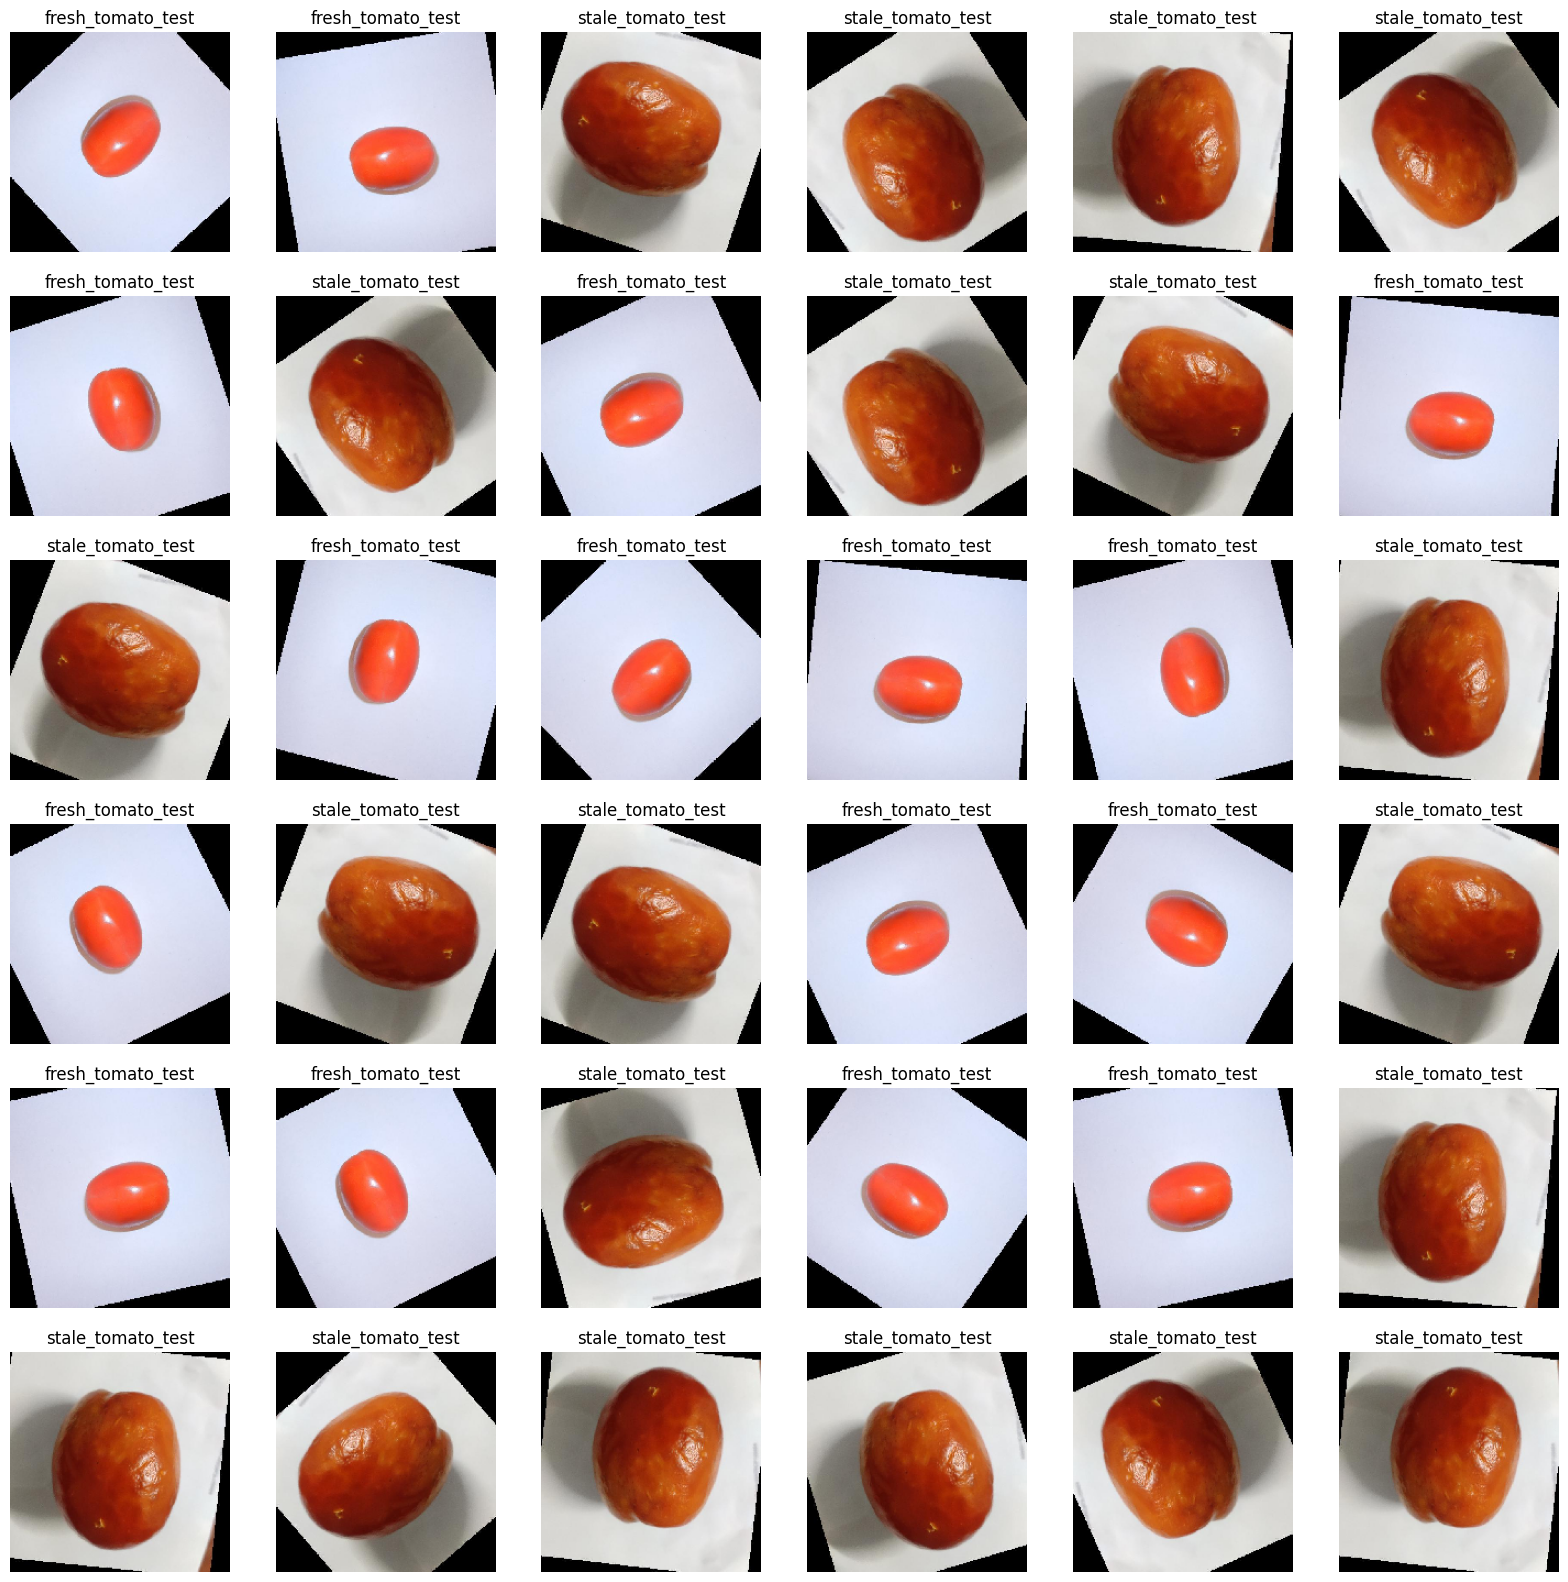

In [8]:
Show_Images(test_generator)

In [9]:
early_stopping = EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=5, # how many epochs to wait before stopping
    restore_best_weights=True,
)
early_stopping = EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=5, # how many epochs to wait before stopping
    restore_best_weights=True,
)

In [10]:
learning_rate_reduce = ReduceLROnPlateau(
    monitor='val_acc',   # Metric to monitor for changes (usually validation accuracy)
    patience=5,          # Number of epochs with no improvement after which learning rate will be reduced
    verbose=1,           # Verbosity mode (0: silent, 1: update messages)
    factor=0.5,          # Factor by which the learning rate will be reduced (e.g., 0.5 means halving)
    min_lr=0.00001       # Lower bound for the learning rate (it won't go below this value)
)

In [11]:
from tensorflow.keras import optimizers

# Create a learning rate schedule using Exponential Decay
learning_rate_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01,  # Initial learning rate for training
    decay_steps=1000,            # Number of steps before decaying the learning rate
    decay_rate=0.5,              # Rate at which the learning rate decreases
)

In [12]:
from keras.callbacks import LearningRateScheduler

# Create a Learning Rate Scheduler callback using a pre-defined schedule
lr_callback = LearningRateScheduler(learning_rate_schedule)
callback=[ lr_callback , learning_rate_reduce ,early_stopping ]

In [13]:
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(size_images, size_images, 3))
for layer in base_model.layers:
    layer.trainable = False


In [14]:
model = tf.keras.models.Sequential([
    base_model,
    
    layers.Flatten(),
    
    layers.Dense(256,activation='relu'),
    layers.Dense(128,activation='relu'),
    layers.Dense(64,activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(2,activation='softmax'),
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 6, 6, 1024)        7037504   
                                                                 
 flatten (Flatten)           (None, 36864)             0         
                                                                 
 dense (Dense)               (None, 256)               9437440   
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 2)                 1

2024-01-20 17:02:54.612652: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 37748736 exceeds 10% of free system memory.
2024-01-20 17:02:54.635832: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 37748736 exceeds 10% of free system memory.
2024-01-20 17:02:54.646774: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 37748736 exceeds 10% of free system memory.


In [15]:
optimizer = optimizers.Adam(learning_rate=learning_rate_schedule)
model.compile(optimizer=optimizer,
             loss="categorical_crossentropy",
              metrics=['accuracy']
             )

In [16]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=10,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size,
    callbacks=[callback]
)


2024-01-20 17:03:33.247185: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 30720000 exceeds 10% of free system memory.


Epoch 1/10


2024-01-20 17:03:36.014519: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 37748736 exceeds 10% of free system memory.


29/29 [==============================] - 129s 4s/step - loss: 17.8079 - accuracy: 0.7002 - val_loss: 0.0053 - val_accuracy: 1.0000 - lr: 0.0098
Epoch 2/10
29/29 [==============================] - 119s 4s/step - loss: 0.2821 - accuracy: 0.8651 - val_loss: 0.0120 - val_accuracy: 1.0000 - lr: 0.0096
Epoch 3/10
29/29 [==============================] - 119s 4s/step - loss: 0.1800 - accuracy: 0.9039 - val_loss: 0.0403 - val_accuracy: 1.0000 - lr: 0.0094
Epoch 4/10
29/29 [==============================] - 122s 4s/step - loss: 0.1328 - accuracy: 0.9361 - val_loss: 0.0201 - val_accuracy: 1.0000 - lr: 0.0092
Epoch 5/10
29/29 [==============================] - 123s 4s/step - loss: 0.1617 - accuracy: 0.9301 - val_loss: 0.0267 - val_accuracy: 1.0000 - lr: 0.0091
Epoch 6/10
29/29 [==============================] - 124s 4s/step - loss: 0.1074 - accuracy: 0.9569 - val_loss: 0.0276 - val_accuracy: 1.0000 - lr: 0.0089


In [17]:
score = model.evaluate(test_generator, verbose=False)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.005445895716547966
Test accuracy: 1.0


<Figure size 640x480 with 0 Axes>

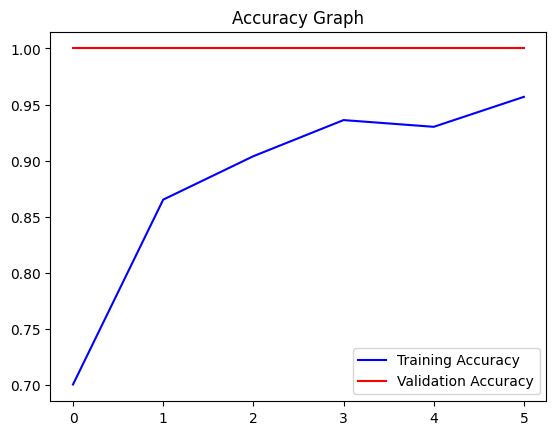

<Figure size 640x480 with 0 Axes>

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

In [19]:
model.save("tomatodense.h5")

/home/bubbles/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [21]:
from keras.models import load_model
import cv2
import numpy as np

# Load the saved model
loaded_model = load_model("tomatodense.h5")

# Function to preprocess the user input image
def preprocess_image(user_image_path):
    # Load the image
    img = cv2.imread(user_image_path)
    # Perform any necessary preprocessing (resizing, normalization, etc.)
    # ...
    # Return the preprocessed image
    return preprocessed_image

# Take user input for an image
user_image_path = input("Enter the path of the image: ")

# Preprocess the user input image
preprocessed_image = preprocess_image(user_image_path)

# Make predictions using the loaded model
predictions = loaded_model.predict(np.expand_dims(preprocessed_image, axis=0))

# You can interpret the predictions based on your specific problem/task
# For example, if it's a binary classification task, you might check:
if predictions[0] > 0.5:
    print("The model predicts class Fresh.")
else:
    print("The model predicts class Stale.")


Enter the path of the image:  /home/bubbles/Downloads/Tomato3.jpeg


NameError: name 'preprocessed_image' is not defined

In [26]:
from keras.models import load_model
import cv2
import numpy as np

# Load the saved model
loaded_model = load_model("tomatodense.h5")
print("Model Loaded")

# Take user input for an image
user_image_path = input("Enter the path of the image: ")

# Load the image and perform necessary preprocessing
img = cv2.imread(user_image_path)
img = cv2.resize(img, (200, 200))  # Replace with your target dimensions
img = img / 255.0  # Normalize the pixel values if needed

# Make predictions using the loaded model
predictions = loaded_model.predict(np.expand_dims(img, axis=0))

# You can interpret the predictions based on your specific problem/task
# For example, if it's a binary classification task, you might check:
#if predictions[0] > 0.5:
 #   print("The model predicts class fresh.")
##   print("The model predicts class stale.")
print(predictions)

Model Loaded


Enter the path of the image:  /home/bubbles/Downloads/Tomato3.jpeg


1/1 [==============================] - 2s 2s/step
[[0.00415006 0.99584997]]
